Tromsø, Troms, Norge
(69.6516345, 18.9558585)
Data lagret i lokasjonsdata.csv


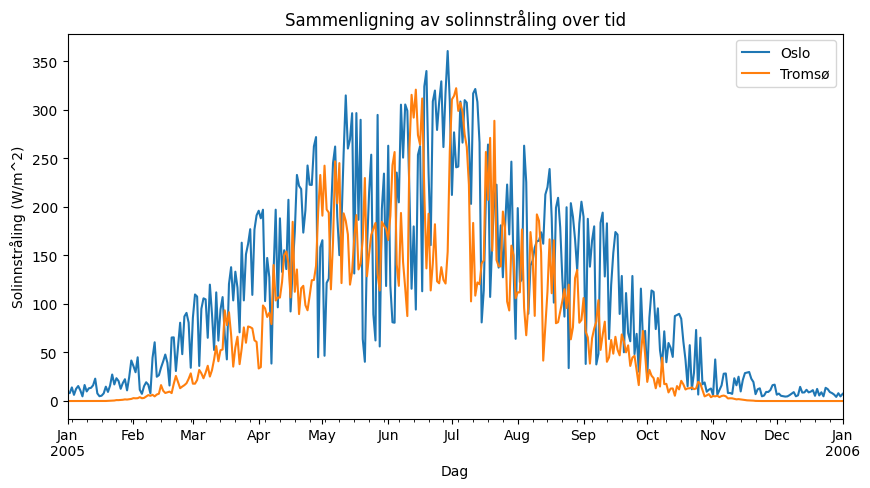

In [2]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import os
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="miljøanalyse_abel")
location = geolocator.geocode(input("location: "))
print(location.address)
print((location.latitude, location.longitude))

# Tidsperiode og API-parametere
starttid = "20050101"  # YYYYMMDD
sluttid = "20060101"  # YYYYMMDD
type = "daily"
lon_min, lon_max = location.longitude - 1.01, location.longitude + 1.01
lat_min, lat_max = location.latitude - 1.01, location.latitude + 1.01

# CSV-fil for samlet data
csv_fil = "lokasjonsdata.csv"

# Sjekk om byen allerede finnes i CSV-filen
location_name = location.address.split(",")[0]  # Hent bynavn fra addressen
if os.path.exists(csv_fil):
    df_tidligere = pd.read_csv(csv_fil, index_col=0, sep="\t", parse_dates=True)
    if location_name in df_tidligere.columns:
        exit(f"Data for {location_name} finnes allerede i filen. Ingen nye data er lagt til.")

# API-forespørsel
url = f"https://power.larc.nasa.gov/api/temporal/{type}/regional?parameters=ALLSKY_SFC_SW_DWN&community=SB&longitude-min={lon_min}&longitude-max={lon_max}&latitude-min={lat_min}&latitude-max={lat_max}&start={starttid}&end={sluttid}&format=JSON"

response = requests.get(url)
if response.status_code == 422:
    exit("Ugyldig forespørsel.")
elif response.status_code == 429:
    exit("For mange forespørsler. Prøv igjen senere.")
elif response.status_code != 200:
    exit(f"Feil ved forespørsel: {response.status_code}")

# Hente ut data fra responsen
data = response.json()["features"][0]["properties"]["parameter"]["ALLSKY_SFC_SW_DWN"]

# Konverter data til en DataFrame
df = pd.DataFrame(list(data.values()), index=pd.to_datetime(list(data.keys())), columns=[location_name])

# Lagre eller oppdatere CSV-fil
if os.path.exists(csv_fil):
    # Kombiner eksisterende data med ny data
    df_sammensatt = pd.concat([df_tidligere, df], axis=1)
else:
    # Ingen tidligere data, bruk kun ny data
    df_sammensatt = df

# Lagre oppdatert DataFrame til CSV
df_sammensatt.to_csv(csv_fil, sep="\t", encoding="utf-8")
print(f"Data lagret i {csv_fil}")

# Plot sammenligning av data
df_sammensatt.columns = [col.split("_")[0] for col in df_sammensatt.columns]  # Fjern tidsperioden fra kolonnenavn
df_sammensatt.plot(figsize=(10, 5))
plt.xlabel("Dag")
plt.ylabel("Solinnstråling (W/m^2)")
plt.title("Sammenligning av solinnstråling over tid")
plt.legend(df_sammensatt.columns)
plt.show()


Gjennomsnitt: 161.760
Standardavvik: 94.605
Median: 155.655


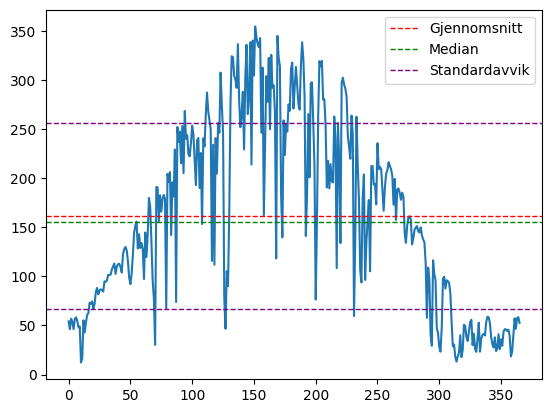

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def average(data):
    return np.mean(data)

def std_dev(data):
    return np.std(data)

def median(data):
    return np.median(data)

std_dev_max = average(df[0]) + std_dev(df[0])
std_dev_min = average(df[0]) - std_dev(df[0])   

print(f"Gjennomsnitt: {average(df[0]):.3f}")
print(f"Standardavvik: {std_dev(df[0]):.3f}")
print(f"Median: {median(df[0]):.3f}")

plt.plot(range(0,len(data.values())),data.values())
plt.axhline(average(df[0]), color='red', linestyle='dashed', linewidth=1, label='Gjennomsnitt')
plt.axhline(median(df[0]), color='green', linestyle='dashed', linewidth=1, label='Median')
plt.axhline(std_dev_max, color='purple', linestyle='dashed', linewidth=1, label='Standardavvik')
plt.axhline(std_dev_min, color='purple', linestyle='dashed', linewidth=1)
plt.legend()
plt.show()
